<a href="https://colab.research.google.com/github/Brun0oO/Colab/blob/main/Prompt_based_Image_In_Painting_powered_by_ClipSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the following notebook: https://github.com/amrrs/stable-diffusion-prompt-inpainting

In [1]:
! git clone https://github.com/timojl/clipseg 

Cloning into 'clipseg'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 200 (delta 47), reused 43 (delta 42), pack-reused 145
Receiving objects: 100% (200/200), 1.39 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
! pip install diffusers -q

     |████████████████████████████████| 255 kB 4.9 MB/s 
     |████████████████████████████████| 163 kB 68.0 MB/s 


In [3]:
! pip install transformers -q -UU ftfy

     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 7.6 MB 46.5 MB/s 


In [4]:
! pip install git+https://github.com/openai/CLIP.git -q

In [16]:
! wget -nc https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O /content/clipseg/weights.zip
! unzip -o -q -d /content/clipseg/weights -j /content/clipseg/weights.zip

--2022-10-28 10:53:57--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/clipseg/weights.zip’

/content/clipseg/we     [     <=>            ]   9.68M  9.01MB/s    in 1.1s    

2022-10-28 10:53:59 (9.01 MB/s) - ‘/content/clipseg/weights.zip’ saved [10146905]



In [6]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [7]:
#@title #Inline inputs 
#@markdown For non-English languages use Google translation:
translate = True #@param {type:"boolean"}
if translate:
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator
  translator = Translator()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 1.4 MB 9.7 MB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 65 kB 4.6 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=86aeae2399813ecd68a74ce4f19258edc5c138600a9b22b861ec67c1468a4385
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


# Interactive inputs

Saving IMG_1390.jpg to IMG_1390.jpg


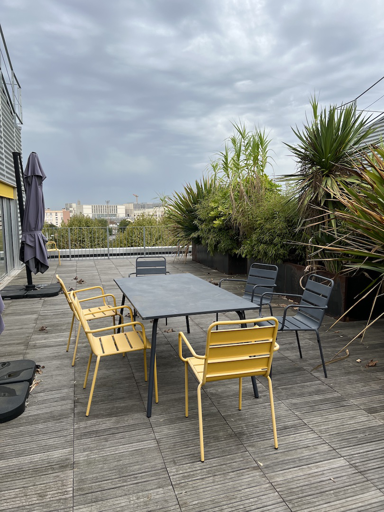

In [8]:
from inspect import EndOfBlock
import os
from PIL import Image 

def upload_files(path_dest):
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(os.path.join(path_dest,k), 'wb').write(v)
  return list(uploaded.keys())


MAX_SIZE = (512, 512)
dest = "/content"
files = upload_files(dest)
input_image = Image.open(os.path.join(dest,files[0])) 
input_image.thumbnail(MAX_SIZE)
  

display(input_image)


In [14]:
input_language = "en"
if translate:
  input_language = input("Input language: ")  
object_prompt = input("Object to replace (language="+input_language+") : ")
if translate:
  object_prompt = translator.translate(object_prompt, src=input_language).text
replace_by_prompt = input("Replace this object by (language="+input_language+") : ")
if translate:
  replace_by_prompt = translator.translate(replace_by_prompt, src=input_language).text



Input language: fr
Object to replace (language=fr) : chaise
Replace this object by (language=fr) : vieux fauteuil


In [18]:
import torch
import requests
import cv2 
from clipseg.models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [19]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [ ]:
#! git lfs install

In [20]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 190MiB/s]


In [21]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [22]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [24]:
!%cd /content/

/bin/bash: line 0: fg: no job control


In [25]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

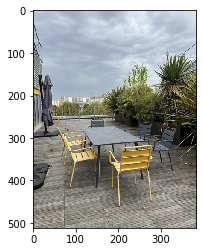

In [26]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [27]:
prompts = [object_prompt]
# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


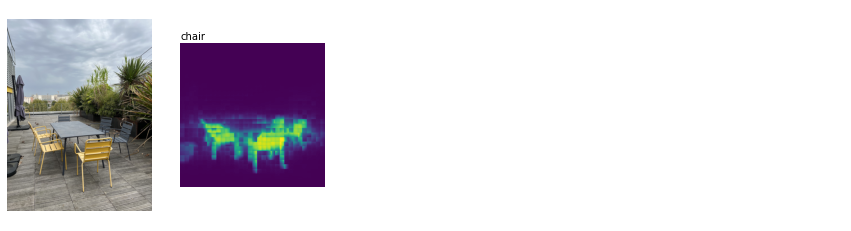

In [28]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [29]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [30]:
img2 = cv2.imread(filename)

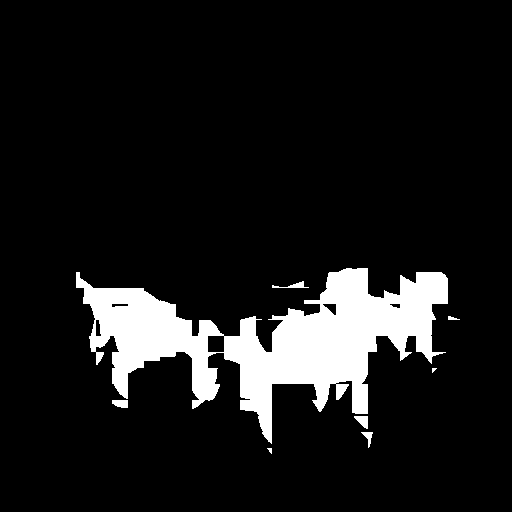

In [31]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

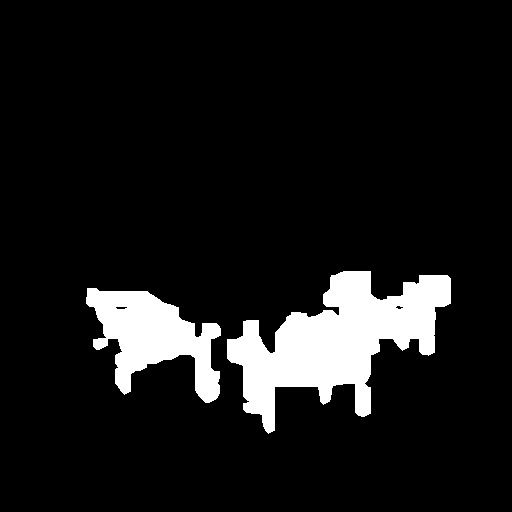

In [32]:
# attempt to enhance the mask
from PIL import Image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
(thresh, binRed) = cv2.threshold(bw_image, 128, 255, cv2.THRESH_BINARY)
smoothed = cv2.morphologyEx(bw_image, cv2.MORPH_OPEN, kernel, iterations=3)
cv2.imwrite(filename,smoothed)
Image.fromarray(smoothed)

In [33]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

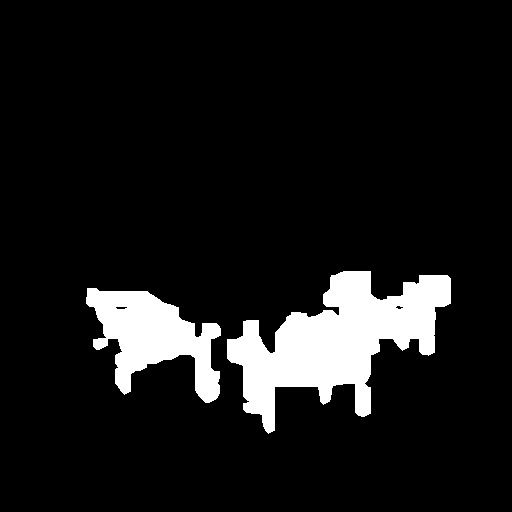

In [34]:
mask

In [35]:
with autocast("cuda"):
    images = pipe(prompt=replace_by_prompt, init_image=init_image, mask_image=mask, strength=0.9)
  

0it [00:00, ?it/s]

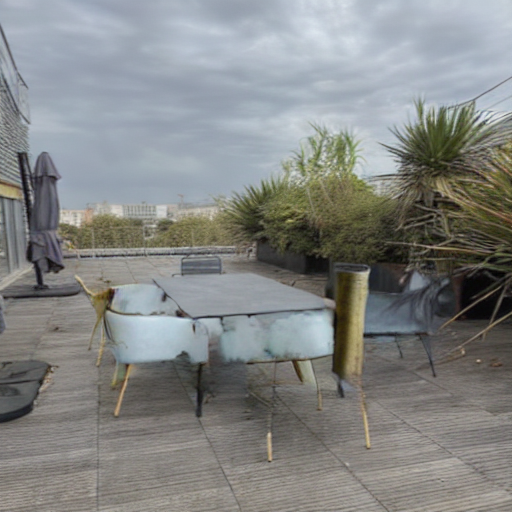

In [36]:
result=images['images'][0]
display(result)